# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections. This Notebook is divided en the following sections.

1. Prerequisites
2. Freeman Segregation

    2.1. Global Freeman Segregation Index

    2.2. Freeman Segregation Index for an specific group

    2.3. Freeman Segregation Index for an specific group (Taking in account Weights)
    
3. Spectral Segregation

4. Results

    4.1. 3 Day Rolling Window
    
4. Conclusion 


## 1. Prerequistes

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
from utils.Functions import *
from utils.Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
from glob import glob
from tqdm import tqdm

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


For the calculation of the segregation Indexes, we define some notation based on (Bojanowski & Corten 2014).

We define a Graph with

$$\mathbb{N}= \{1, \dots, i, \dots, N\}$$

and then, define the set

$$\mathbb{G} = \{G_1, G_2,\dots, G_k\}$$

as the set of $K$ groups in which every $G_g$ is a subset of $\mathbb{N}$ that contains all the nodes that belong to group $g$. define $\eta_{k}$ = $|G_k|$ as the amount of nodes from group $G_k$

Now we define the type vector as 

$$\textbf{t} = [t_1,\dots, t_i, \dots, t_N]$$

where $t_i \in \{1,\dots,K\}$. This vector matches every node with its corresponding group. Using this notation. We can define a type indicator vector for each group $k$ as follows:  

$$\textbf{v}_k = [v_1, \dots, v_i, \dots, v_N]$$ 

where $v_i \in \{0,1\}$. This vector has one entry for every node and the node location will have a 1 if that node corresponds to the group $G_k$. Formally:

$$ v_i = \begin{cases} 1 &\text{ if }t_i = k \\ 0 &\text{ if }t_i \neq k \end{cases} $$

Now we define the Types Matrix $T_{N\times K}$ as a matrix that contains the information of each node and wich group it represents. For Every column of the matrix corresponds to a $\textbf{v}_k$ _types indicator vector_.

In the context of this Research, we will use a Directed Weighted Graph. Our nodes are X (formmerly Twitter) in which the user $i$ is related to the user $j$ if $i$ Retweeted a Tweet without comments of $j$. In this sense. Formarly we discribe the relationship $R$ over $\mathbb{N}\times \mathbb{N}$ that implies our square Adjcency Matrix $X = [X_{ij}]_{\mathbb{N}\times \mathbb{N}}$

For the segregation calculations will will consider the graph as weighted or un weight. In case of takin in account the weights of each edge, eh entries of the Adjacency Matrix will be defined as follows:

$$x_{ij} = \dfrac{\text{\# Tweets from }j\text{ that }i\text{ Retweeted without comments}}{\text{\# of Retweets without comments from }i}$$

Taking in account the unweighted graph, we will define our Simple Adjacency Matrix as:

$$ x_{ij} = \begin{cases} 1 & \text{if } i\text{ Retweeted }j \\ 0 & \text{In other case} \end{cases} $$

Finally, we define the _Mixing Matrix_ ($M_{ghy}$) where $g$ and $h$ are two generic groups and $y$ indexes two types of layers. The first layer _Mixing Matrix_ is the _Contact layer_, defined as follows: (Where we use the weighted or un weighted adjcancecy matrix):

$$M_{gh1} = \sum_{i\in G_g}\sum_{j\in G_h} x_{ij}$$

For the **unweighted** case, we can define the _No Contact Layer_ as follows:

$$M_{gh0} = \sum_{i\in G_g}\sum_{j\in G_h} (1-x_{ij})$$

Finally, in this matrix $M_{gh1}$ shows the amount of attention that group $h$ gets from group $g$

For easyness, we define the follow notation:

- $M_{g+1} = \sum_{g=1}^K M_{gh1}$ Sum across a row

- $M_{+h1} = \sum_{h=1}^K M_{gh1}$ Sum across a column

- $M_{++1} = \sum_{g=1}^K \sum_{h=1}^K M_{gh1}$ Sum of all the Layer

In [11]:
# Indexes
date_range = pd.date_range(start='2021-05-01', end='2021-06-30', freq='D')
categories = ['Izquierda', 'Derecha', 'Centro', 'No Retweets']
multi_index = pd.MultiIndex.from_product([date_range, categories], names=['Date', 'Political Label'])

# DataFrames with statistics
global_segregation = pd.DataFrame(index=date_range).sort_index()
group_segregation = pd.DataFrame(index=multi_index).sort_index()

# Load graphs
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

## 2. Freman Segregation

### 2.1 Basic Freeman Segregation

The basic segregation index proposed by Freeman (1998) tries to see how is the proportion of ties between two different groups against the ties if they were made randomly. This Basic Index is calculated for undirected and unweighted graphs. It is the first approch for segregation for this family of indexes. We define the $\eta_1$ as the amount of nodes belonng to group $G_1$ and $\eta_2$ belonging to group $G_2$. Recalling our past notation, in the contact Layer of the mixing matrix the number of between group ties will be the entry $M_{121}$. We can divide this numero over all the amount of edges (Note that the nuber of edges in the graph is equal to the sum of all the contact layer $M_{++1}$). This is how we get the proportion of between ties

$$p = \frac{M_{121}}{M_{++1}}$$

Now, we calculate the expected value of $p$ Note that the probability of taking a tie between the node of a one group and a node with the other group will be conjunct probabilty of taking a dyad with a node beloging to $G_1$ out of the total of dyads and doing the same for a dyad with a node from group $G_2$. (Note that the number of dyads corresponds to _N choose 2_)

$$\pi = \frac{\eta_1}{\frac{N(N-1)}{2}} \times \frac{\eta_2}{\frac{N(N-1)}{2}} = \frac{2\eta_1 \eta_2}{N(N-1)}$$

Finally Freeman Segregation Index is defined as:

$$S_{Freeman} = 1- \frac{p}{\pi}$$

In [21]:
def Freeman_Two_Groups(g: gt.Graph, types:str):
    M = get_contact_layer(g, types=types)
    
    assert M.shape[0] == M.shape[1] == 2, 'Usar Freeman_Group_Global'
    
    cross_ties = M[0,1]
    edges = g.num_edges()
    nodes = g.num_vertices()
    
    P = cross_ties/edges
    print(f"P: {P}")
    types_matrix = get_types_matrix(g, types = types)
    
    n_1 = np.sum(types_matrix[:, 0])
    n_2 = np.sum(types_matrix[:, 1])
    
    Pi = (2*n_1*n_2)/(nodes * (nodes - 1))
    print(f"Pi: {Pi}")
    return 1 - (P / Pi) 

g = gt.load_graph('/mnt/disk2/Data/3_Day_Graphs/2021-06-12.graphml')

print(Freeman_Two_Groups(g,'Centro'))
print(Freeman_Groups_No_Weight(g, 'Political Label', 'Centro'))

P: 0.08892786469454886
Pi: 0.18911332746097642
0.5297641584097285
0.5297641584097285


In [20]:
# Storage in DataFrame
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0]
        seg = Freeman_Two_Groups(g,types = pol)
        group_segregation.loc[(graph_name, pol), 'Freeman Two Groups'] = seg
        print(file, pol, seg)

  0%|          | 0/61 [00:00<?, ?it/s]

/mnt/disk2/Data/3_Day_Graphs/2021-06-12.graphml Izquierda 0.3375602617055341
/mnt/disk2/Data/3_Day_Graphs/2021-06-12.graphml Derecha 0.9008708991688683
/mnt/disk2/Data/3_Day_Graphs/2021-06-12.graphml Centro 0.8948787241726859


  0%|          | 0/61 [00:11<?, ?it/s]


KeyboardInterrupt: 

### 2.2 Global Freeman Segregation Index (for K groups)

For the Freeman Segregation Index, We will use the formula from (Bojanowski & Corten 2014) for the in which the generalize this index for $K$ groups. The index is define as Follows.

Let $p$ be equal to the proportion of _between_ group ties in the graph. This corresponds to the upper triangle of the $M$ Matrix without counting the diagonal (This diagonal contains the information of the _within_ group ties).

$$p = \frac{\sum_{g,h:g\neq h}M_{gh1}}{\sum_{g=1}^K\sum_{h=1}^K M_{gh1}}$$

Now, we define the expected proportion of between-group ties in a random graph. In the generalize case of $K$ groups. this looks like this

$$\pi = \frac{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}{N(N-1)}$$

Finally, Freeman Segregation Index is defined as:

$$S_{Freeman} = 1 -\frac{p}{\pi} = 1- \frac{pN(N-1)}{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}$$

This Index takes into account the case **unweighted case**

In [15]:
# Storage in DataFrame
for file in tqdm(files):
    g = gt.load_graph(file)
    graph_name = file.split('/')[-1].split('.')[0]
    seg = Freeman_Global_No_Weight(g,types = 'Political Label')
    global_segregation.loc[(graph_name), 'Freeman No Weighted'] = seg

100%|██████████| 61/61 [03:56<00:00,  3.88s/it]


### 2.3 Freeman Segregation Index for an specific group

The Freeman Segregation Index is originally computed for the segregation between two groups. This function will compute the index between one group and all the other ones using _Basic Freeman Segregatioon Index_ Formula. This will give a measure of how segregated is one group over all the others. For this case, our contact layer will only consider two groups, the group $g$ for which one would calculate the index and the group $-g$ wich are all the other nodes that do not belong to $g$. Recall our _Contact Matrix_ that looks like this:

$$
M_{gh1} = 
\begin{bmatrix}
    M_{1,1,1} & M_{1,2,1} & \dots & M_{1,k,1} \\
    M_{2,1,1} & M_{2,2,1} & \dots & M_{2,k,1} \\
    \vdots & \vdots & \ddots & \vdots \\
    M_{k,1,1} & M_{k,2,1} & \dots & M_{k,k,1} \\
\end{bmatrix}
$$

For our calculation, we will  have another _Contact Catrix_ called, "Me Vs Ohers" and denoted $\hat{M}$. This matrix will be a $2\times 2$. This will be similar as the the original _Contact Matrix_ but with only two groups, $g$ and $-g$. This matrix is defined as follows:

$$
M^* = 
\begin{bmatrix}
    M*_{gg} & M*_{g-g} \\
    M*_{-gg} & M*_{-g-g} \\
\end{bmatrix}
$$

Where:
- $M^*_{g-g} = M_{gg1}$
- $M^*_{g-g} = \sum_{g = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-gg} = \sum_{h = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-g-g} = \sum \sum \hat{M}_{gh}$

For the calculation of the $M*_{-g-g1}$ we substract from the original _Contact Matrix_ the index rows and columns for the group $g$ (Will be denoted as $\hat{M}$). This will be the contact matrix if this group hadn't existed. Thanks to this matrix, we can compute all the between ties from all nodes that aren't in $g$. This will be the sum of all the values in the matrix. Formally,
$$
\hat{M} = 
    \begin{bmatrix}
    a_{1,1} & \dots & a_{1,g-1} & a_{1,g+1} & \dots & a_{1,k} \\
    a_{2,1} & \dots & a_{2,g-1} & a_{2,g+1} & \dots & a_{2,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{g-1,1} & \dots & a_{g-1,g-1} & a_{g-1,g+1} & \dots & a_{g-1,k} \\
    a_{g+1,1} & \dots & a_{g+1,g-1} & a_{g+1,g+1} & \dots & a_{g+1,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{k,1} & \dots & a_{k,g-1} & a_{k,g+1} & \dots & a_{k,k} \\
\end{bmatrix}
$$

Now, for the Freeman Formula we compute both $P$ and $\pi$ and calculate $1-\frac{P}{\pi}$

$$P = \frac{M^*_{12}}{M^*_{++}}$$

$$\pi = \frac{2|G_g|*|G_{-g}|}{N(N-1)}$$

$$S_{Freeman}^g = 1- \frac{N(N-1)M^*_{12}}{2M^*_{++}|G_g||G_{-g}|}$$

In [14]:
# Storage in DataFrame
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0]
        seg = Freeman_Groups_No_Weight(g,types = 'Political Label', group = pol)
        group_segregation.loc[(graph_name, pol), 'Freeman No Weighted'] = seg

100%|██████████| 61/61 [16:00<00:00, 15.74s/it]


### 2.2 Freeman Segregation Index for an specific group (Taking in account Weights)
The function described below is intended to be use with the weighted graph. We will use precious notation for this formula.

$$P = \frac{M^*_{12}}{M^*_{12} + M^*_{11}}$$

$$\pi = \frac{|G_g|}{N}$$

In this case, the Freeman Segregation Index for a weighted and directed graph is equal to:

$$S_{Freeman}^g = 1-\frac{P}{\pi}$$

In [16]:
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0]
        seg = Freeman_Groups_Weight(g, weights='Normal Weights',group = pol, types = 'Political Label')
        group_segregation.loc[(graph_name, pol), 'Freeman Weighted'] = seg

100%|██████████| 61/61 [16:00<00:00, 15.74s/it]


In [17]:
group_segregation.head()

Freeman Two Groups  Freeman No Weighted  \
Date       Political Label                                            
2021-05-01 Centro                     0.909360             0.525626   
           Derecha                    0.913981             0.466362   
           Izquierda                  0.266809             0.446781   
           No Retweets                0.914545             0.494191   
2021-05-02 Centro                     0.899964             0.535258   

                            Freeman Weighted  
Date       Political Label                    
2021-05-01 Centro                   0.063151  
           Derecha                 -0.076253  
           Izquierda               -0.188097  
           No Retweets              0.056075  
2021-05-02 Centro                   0.072960

In [ ]:
global_segregation.head()

In [ ]:
group_segregation.to_pickle('/mnt/disk2/Data/Pickle/group_segregation.pkl')
global_segregation.to_pickle('/mnt/disk2/Data/Pickle/global_segregation.pkl')

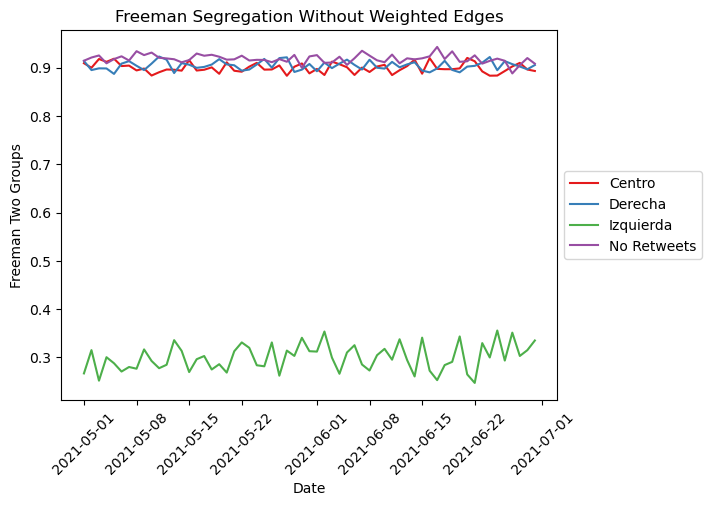

In [8]:
# Resetting index to make 'Date' a column for Seaborn's use
df = group_segregation.reset_index()

# Plotting using Seaborn with different colors for each category
chart = sns.lineplot(data = df, x = 'Date', y ='Freeman Two Groups', hue='Political Label', palette='Set1')
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 0.5),loc='center left')
plt.title('Freeman Segregation Without Weighted Edges')
plt.show(chart)

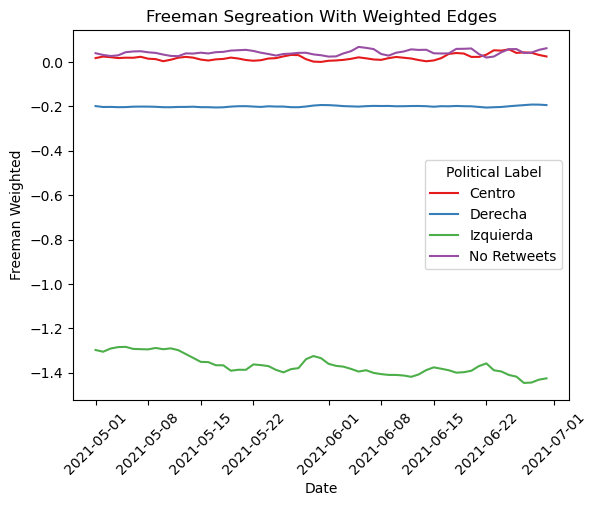

In [150]:
# Plotting using Seaborn with different colors for each category
chart = sns.lineplot(df, x = 'Date', y ='Freeman Weighted', hue='Political Label', palette='Set1', errorbar=None)
plt.xticks(rotation=45)
plt.title('Freeman Segregation With Weighted Edges')
plt.show(chart)

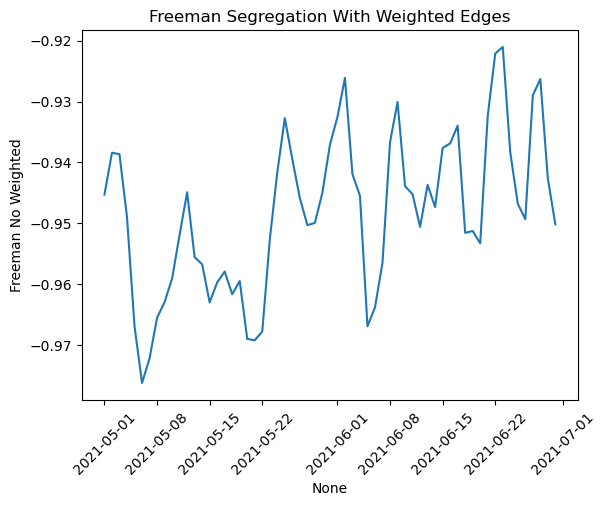

In [152]:
# Plotting using Seaborn with different colors for each category
chart = sns.lineplot(global_segregation, x = global_segregation.index, y ='Freeman No Weighted', errorbar=None)
plt.xticks(rotation=45)
plt.title('Freeman Segregation With Weighted Edges')
plt.show(chart)

## 2. 3 Day rolling window Segregation Indexes

### 1. Freeman Segregation Index

In [104]:
# Load graphs
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

# Store results
viz_per_group = []
viz_global = []

for file in files:
    g = gt.load_graph(file)
    graph_name = file.split('/')[-1].split('.')[0]
    # Segregation per group
    keys = list(get_types_index(g,types = 'Political Label').keys())
    for key in keys:
        data_per_group = {
            'date': [graph_name],
            'type': [key],
            'Freeman with Weights': [Freeman_Groups_Weight(g, weights='Normal Weights',group = key, types = 'Political Label')],
            'Freeman No Weights': [Freeman_Groups_No_Weight(g, group = key, types = 'Political Label')]
        }
        df = pd.DataFrame(data_per_group, index = None)
        viz_per_group.append(df)
    # Global Measures
    data_global = {
        'Freeman Global': [Freeman_Global_No_Weight(g,types = 'Political Label')],
        'date': [graph_name],
    }
    df = pd.DataFrame(data_global, index = None)
    viz_global.append(df)
# We create a Dataframe for Visualization
viz_per_group = pd.concat(viz_per_group)
viz_global = pd.concat(viz_global)

# Transform the list to a big dataframe
viz_per_group['date'] = pd.to_datetime(viz_per_group['date'], format='%Y-%m-%d')
viz_per_group = viz_per_group.set_index('date')
viz_per_group = viz_per_group.sort_index()

# Transform the list to a big dataframe
viz_global['date'] = pd.to_datetime(viz_global['date'], format='%Y-%m-%d')
viz_global = viz_global.set_index('date')
viz_global = viz_global.sort_index()

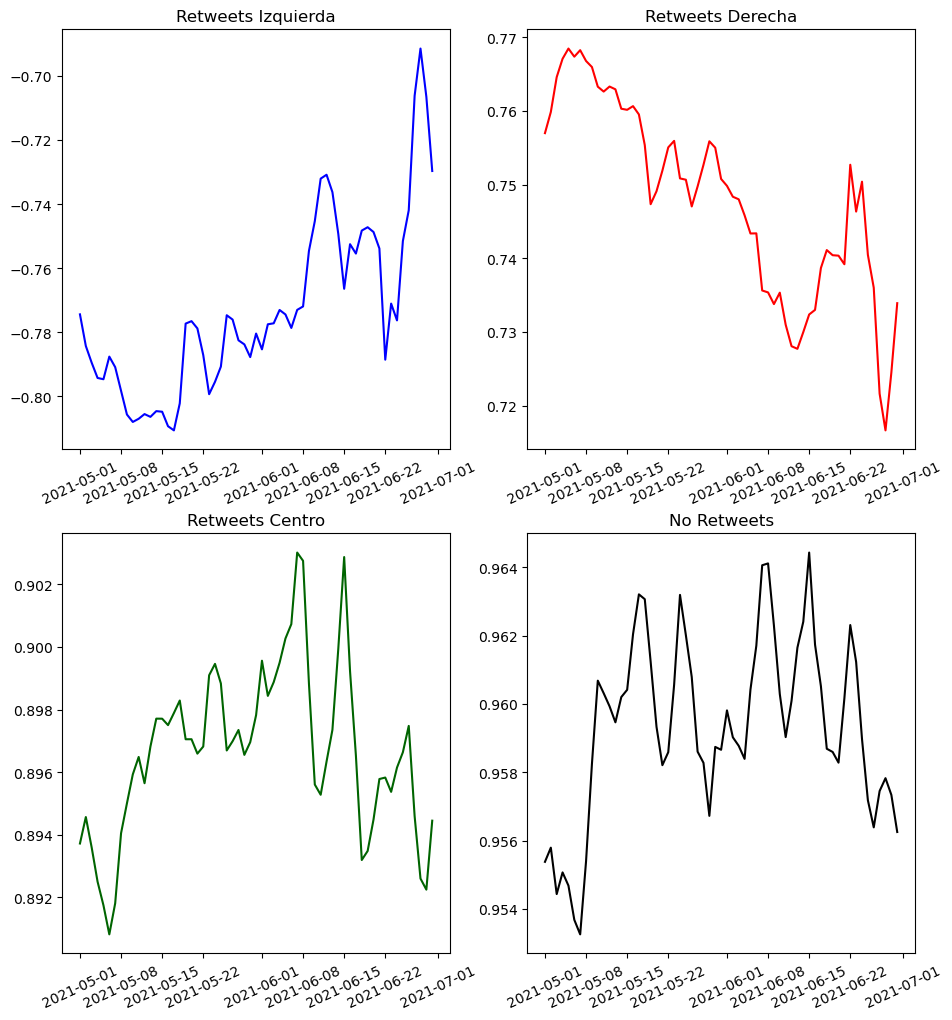

In [109]:
# Calculating number of axes
sq = int(np.ceil((np.sqrt(len(viz_per_group['type'].unique())))))
fig, axes = plt.subplots(nrows=sq, ncols=sq, figsize=(11,12))

# ColorMap
color = {
    'Retweets Izquierda': 'blue',
    'Retweets Derecha': 'red',
    'Retweets Centro': 'darkgreen',
    'No Retweets': 'black'
}

for i, type in enumerate(viz_per_group['type'].unique()):
    seg = viz_per_group[viz_per_group['type'] == type]
    ax = axes[i // sq, i % sq]
    sns.lineplot(data=seg, x=seg.index, y='Freeman with Weights', color=color[type], ax=ax)
    
    ax.set_title(type)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(type)
    ax.set_ylabel('')
        

#plt.suptitle('Line Plots by Type')
plt.show()

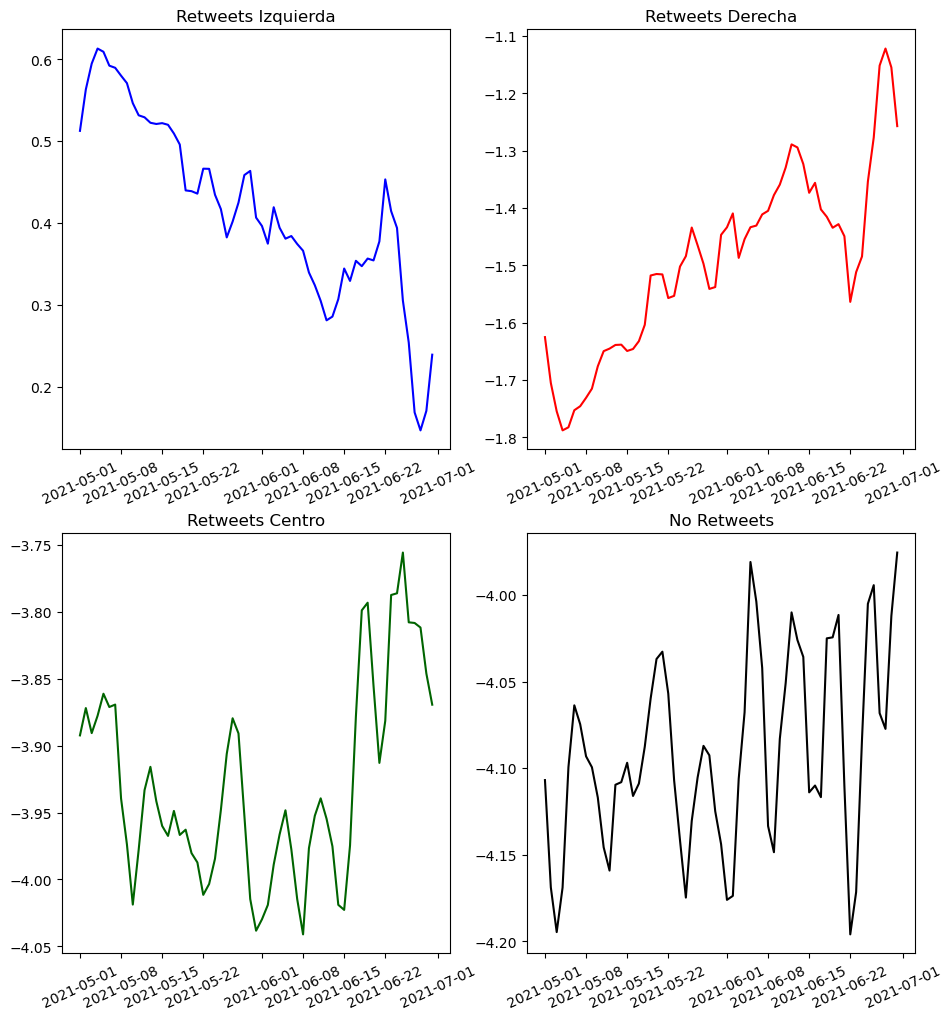

In [110]:
fig, axes = plt.subplots(nrows=sq, ncols=sq, figsize=(11,12))

for i, type in enumerate(viz_per_group['type'].unique()):
    seg = viz_per_group[viz_per_group['type'] == type]
    ax = axes[i // sq, i % sq]
    sns.lineplot(data=seg, x=seg.index, y='Freeman No Weights', color=color[type], ax=ax)
    
    ax.set_title(type)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(type)
    ax.set_ylabel('')
        
plt.show()

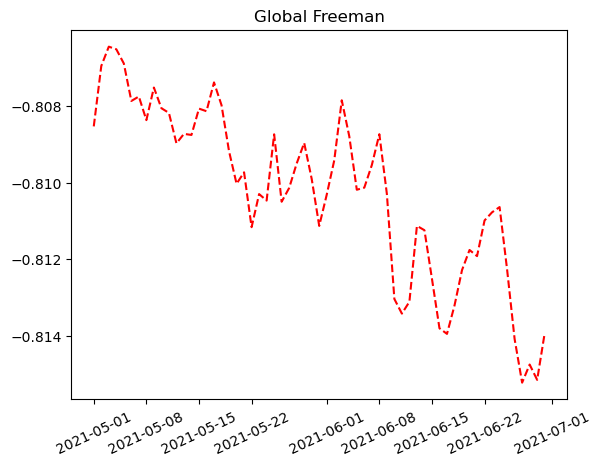

In [113]:
fig, ax = plt.subplots()
sns.lineplot(data=viz_global, x=viz_global.index, y='Freeman Global', color='red', ax=ax, linestyle='--')
    
ax.set_title('Freeman Global')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=25)
ax.set_title('Global Freeman')
ax.set_ylabel('')

plt.show()

### 2. Spectral Segregation Index

In [ ]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
viz_per_group = []

# This takes a While XD (runtime: 1 Hour aprox)
for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    data = Spectral_Segregation_Index(adj,types,user_indices)
    data['date'] = adjacency_name

    #Appending it to the data Visualization list
    viz_per_group.append(data)

# We create a Dataframe for Visualization
viz_per_group = pd.concat(viz_per_group)

# Transform the list to a big dataframe
viz_per_group['date'] = pd.to_datetime(viz_per_group['date'], format='%d-%m-%Y')

# Pivot to long format
viz_per_group = pd.melt(viz_per_group,
                    id_vars=['date'],
                    value_vars=['Dummy Derecha', 'Dummy Centro', 'No Retweets'], var_name='Group', value_name='segregation')

print("DataFrame in long format:")
viz_per_group.head()

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


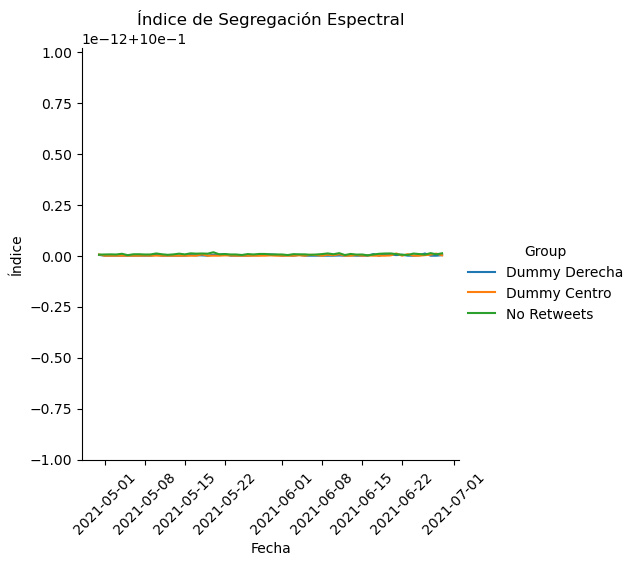

In [10]:
# Figure Mapping
sns.relplot(data = viz_per_group,
            x ='date',
            y = 'segregation',
            kind = 'line',
            hue = 'Group')

# Labels
plt.title('Índice de Segregación Espectral')
plt.ylabel('Índice')
plt.xlabel('Fecha')

# Others
plt.xticks(rotation=45)
plt.show()